# Volatility Models

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahoo_fin import stock_info
from scipy import optimize as opt

**Objective:**

To estimate the daily variance rate for Nifty 50 index and produce the term structure for volatility using the following volatility updating methods:
1. Exponentially Weighted Moving Average (EWMA)
2. GARCH (1,1) Model

The following steps are followed in both methods:
1. Calibrate the model parameters using maximum likelihood estimation (MLE)
2. Forecast the future volatility per day
3. Calculate the term structure as average volatiltiy per annum between two time periods

**Nifty 50 Data:**

In [6]:
start='2019-01-01'
end='2021-03-31'

In [7]:
nifty_prices = stock_info.get_data('^NSEI',start_date=start,end_date=end)['adjclose']

In [8]:
nifty_returns = pd.Series(data = nifty_prices.values[1:]/nifty_prices.values[:-1]-1,index=nifty_prices[1:].index)

In [9]:
nifty_returns= nifty_returns.dropna()

Text(0.5, 1.0, 'Nifty 50 returns as a function of Time')

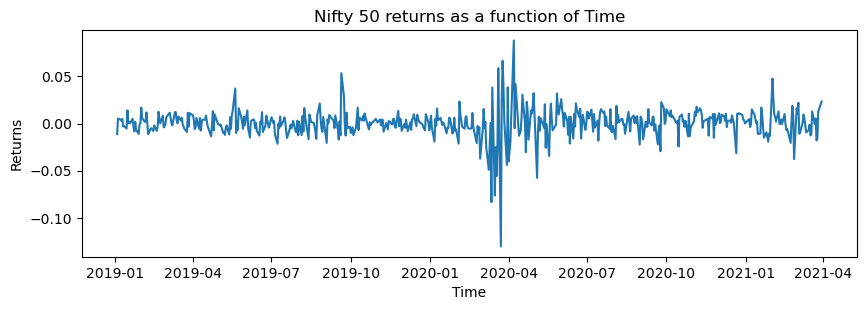

In [10]:
plt.figure(figsize=(10,3),dpi=100)
plt.plot(nifty_returns)
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Nifty 50 returns as a function of Time')

From the above plot, we can see that the returns are not stationary throughout time. The variance of the returns during the first half of 2020 is much greater than the average volatility. Such a condition is called heteroscedasticity. Models predicting returns assuming constant variance throughout time will be incorrect and predictions given by those models will be invalid. Therefore we use models which assume the variance changes throughout time to forecast the variance.

An estimate of the future volatility can be obtained by using historical data. But since the volatility is not constant throughout time, this is not good estimate of the future volatility.

In [11]:
t = [10,30,60,90,180,360,500]
hist_vol = [(np.var(nifty_returns[-1-i:-1])*252)**0.5 for i in t]
pd.DataFrame(data=hist_vol,index=t,columns=['Volatility based on recent t days data'])

,Volatility based on recent t days data
10,0.168233
30,0.204046
60,0.207107
90,0.189095
180,0.175545
360,0.275680
500,0.249239


**EWMA:**

The EWMA model estimates the current variance by assigning exponentially decreasing weights to past returns instead of equal weighting in historical methods. The mathematical representation of the model is: $\sigma_n^2 = \lambda \sigma_{n-1}^2+ (1-\lambda)u_{n-1}^2$

where $\sigma_n^2$ is the estimated variance rate for the nth day and $u_n$is the return for the nth day. The parameter $\lambda$ is the weightage given to past observations. It has to be estimated using Maximum Likelihood Estimation.

In [12]:
def EWMA(l,returns):
    EWMA_list =np.empty(shape=(len(returns)))
    EWMA_list[1] =returns[0]**2
    for i in range(2,len(returns)):
        EWMA_list[i] = l*EWMA_list[i-1]+(1-l)*returns[i-1]**2
    return EWMA_list

Estimating the optimal value of l using MLE. The asset returns are assumed to be normally distributed.

In [13]:
log_likelihood_normal = lambda x,s:sum(-np.log(s)-(x**2/s))*-1

In [14]:
f = lambda l1: log_likelihood_normal(nifty_returns[1:],EWMA(l1,nifty_returns)[1:])

In [15]:
l_min = opt.minimize_scalar(f,bounds=(0,1),method='bounded').x
print(f'The optimal value of lambda is {np.round(l_min,3)}')

The optimal value of lambda is 0.885


The calibrated EWMA Model is $\sigma_n^2 = 0.885\sigma_{n-1}^2+ 0.115u_{n-1}^2$. Calculating the volatility based on EWMA.

In [16]:
EWMA_fit = EWMA(l_min,nifty_returns)[1:]
EWMA_vol = (EWMA_fit*252)**0.5

**GARCH(1,1) Model:**

GARCH stands for Generalized Auto Regressive Conditional Heteroscedasticity. The model, similar to EWMA, assigns decreasing weights to past observations. But it also assigns a weight to the long term variance rate.  A general GARCH model of order (p,q) can be represented mathematically as:

$\sigma_n^2 = \omega + \sum_{i=1}^{p} a_i u_{n-i}^2+ \sum_{j=1}^{q} b_j \sigma_{n-j}^2$. Here $\omega = \gamma V_L, V_L$ is the long term variance rate and $\gamma +\sum_{i=1}^{p} a_i +\sum_{j=1}^{q}b_j = 1 $

When $(p,q) =(1,1)$ the model reduces to $\sigma_n^2 = \omega + a u_{n-1}^2+ b \sigma_{n-1}^2.$ Here the parameters $\omega,a,b$ needs to estimated by MLE.

In [17]:
def garch_one_one(params,returns):
    w = params[0]
    a = params[1]
    b = params[2]
    garch_list =np.empty(shape=(len(returns)))
    garch_list[1] = w+(a+b)*returns[0]**2
    
    for i in range(2,len(returns)):
        garch_list[i] = w+a*returns[i-1]**2+b*garch_list[i-1]
    return garch_list

Estimating the parameters using MLE:

In [18]:
g = lambda p1: log_likelihood_normal(nifty_returns[1:],garch_one_one(p1,nifty_returns)[1:])

In [19]:
params = opt.minimize(g,x0=[0.01,0.2,0.5],bounds=[(0.00000001,1),(0.00001,1),(0.00001,1)]).x

In [20]:
w = params[0]
a = params[1]
b= params[2]
V_l = w/(1-a-b)
print('The optimal values of omega,a,b are ({0:.3},{1:.3},{2:.3})'.format(*params))
print(f'The long term volatility estimated is {np.round((V_l*252)**0.5,3)}')

The optimal values of omega,a,b are (1.01e-05,0.213,0.74)
The long term volatility estimated is 0.232


The calibrated GARCH Model is $\sigma_n^2 = 0.00001 + 0.213 u_{n-1}^2+ 0.74 \sigma_{n-1}^2$. Calculating the volatility based on the model.

In [21]:
garch_fit = garch_one_one(params,nifty_returns)[1:]
garch_vol = (garch_fit*252)**0.5

### Comparing both the models:

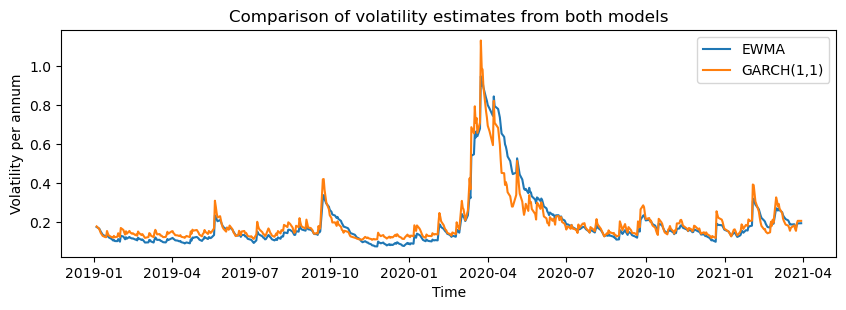

In [22]:
plt.figure(figsize=(10,3),dpi=100)
plt.plot(nifty_returns[1:].index,EWMA_vol,label = 'EWMA')
plt.plot(nifty_returns[1:].index,garch_vol,label ='GARCH(1,1)')
plt.xlabel('Time')
plt.ylabel('Volatility per annum')
plt.title('Comparison of volatility estimates from both models')
plt.legend()

The following plot shows the fitted values for both the models. It can be seen that both estimates are almost closer. But the difference comes when forecasting future volatility.

In [23]:
t_f = np.array([i for i in range(1,101)])

In [24]:
sq_returns_estimate_EWMA = np.array([EWMA_fit[-1] for i in range(101)])

In [29]:
EWMA_fcst = np.array([EWMA_fit[-1] for i in range(1,101)])
garch_fcst = (garch_fit[-1]-V_l)*(a+b)**t_f+V_l

EWMA_fcst_vol = (EWMA_fcst*252)**0.5
garch_fcst_vol = (garch_fcst*252)**0.5

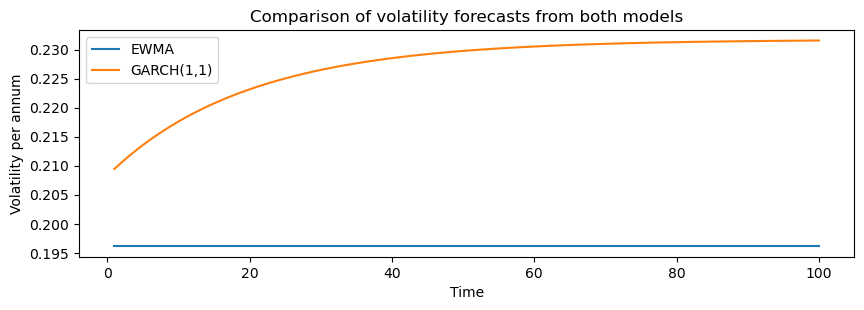

In [31]:
plt.figure(figsize=(10,3),dpi=100)
plt.plot(t_f,EWMA_fcst_vol,label = 'EWMA')
plt.plot(t_f,garch_fcst_vol,label ='GARCH(1,1)')
plt.xlabel('Time')
plt.ylabel('Volatility per annum')
plt.title('Comparison of volatility forecasts from both models')
plt.legend()

The volatility forecast for the EWMA is the same as the volatility predicted at time 0. But the GARCH model produces volatility estimates that revert back to the long term volatility. Due to this property, GARCH model is preferred for forecasting volatility.

**Calculating the volatility term structure based on GARCH(1,1).**

In case of pricing options, we need to use the average volatility as per the time to expiry of the option.

Text(0.5, 1.0, 'Plot of average volatility between 0 to t')

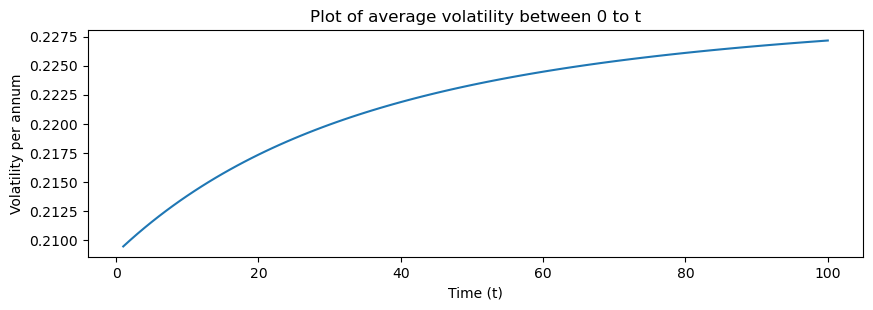

In [39]:
av_vol = np.cumsum(garch_fcst_vol)/t_f
plt.figure(figsize=(10,3),dpi=100)
plt.plot(t_f,av_vol)
plt.xlabel('Time (t)')
plt.ylabel('Volatility per annum')
plt.title('Plot of average volatility between 0 to t')